# Fig. 2: Phosphene drawings vary across electrodes

In [1]:
import os
import os.path as osp
import numpy as np
import pandas as pd

import argus_shapes as shapes

%matplotlib inline
import matplotlib.pyplot as plt

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2019-05-08 11:19:00,346 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
# Assumes all data live in a directory ${DATA_ROOT}/argus_shapes, where DATA_ROOT is
# an environment variable. See README.md on GitHub.
# If no such environment variable exists, data will be automatically downloaded from
# OSF and stored in '../data/argus_shapes'
rootfolder = os.environ['DATA_ROOT'] if 'DATA_ROOT' in os.environ else osp.join('..', 'data')
datafolder = osp.join(rootfolder, 'argus_shapes')

In [3]:
# Load subject data:
subjectdata = shapes.load_subjects(osp.join(datafolder, 'subjects.csv'))
# A scaling factor is used when showing the drawings for the sake of visibility:
subjectdata['scale'] = pd.Series([0.75, 0.75, 2, 0.5], index=subjectdata.index)
subjects = subjectdata.index.sort_values()

In [4]:
# Load drawings:
Xy = shapes.load_data(osp.join(datafolder, 'drawings_single.csv'))

In [5]:
# Average trial-based drawings so we have one drawing per subject/electrode
# Don't binarize (thresh=False), don't exclude inconsistent mean drawings (max_area=inf):
Xymu = shapes.calc_mean_images(Xy, thresh=False, max_area=np.inf)

In [6]:
assert Xy.electrode.unique().sort() == Xymu.electrode.unique().sort()

In [7]:
# Pick the most and least consistent electrode for each subject:
best_worst = pd.DataFrame([
    {'subject': 'S1', 'best': 'D2', 'worst': 'D1'},
    {'subject': 'S2', 'best': 'C10', 'worst': 'F2'},
    {'subject': 'S3', 'best': 'E1', 'worst': 'C10'},
    {'subject': 'S4', 'best': 'F9', 'worst': 'C4'}
]).set_index('subject')

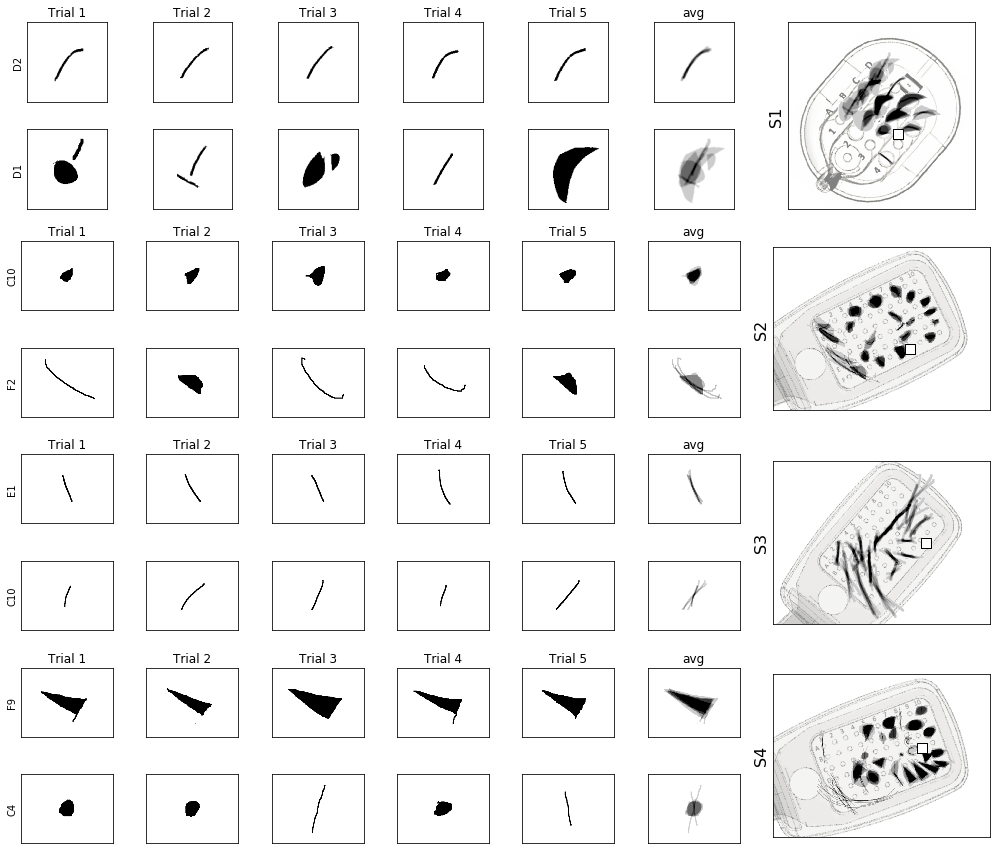

In [8]:
fig = plt.figure(figsize=(14, 3 * len(subjects)))
scale_trials = 2.5

for s, subject in enumerate(subjects):
    # Show mean images overlaid on array schematic:
    ax1 = plt.subplot2grid((2 * len(subjects), 8), (s * 2, 6), rowspan=2, colspan=2)
    shapes.viz.plot_phosphenes_on_array(ax1, subject, Xymu, subjectdata, show_fovea=True)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_ylabel(subject, fontsize=16)
    # Show trial and mean images for the best and worst electrode:
    for r, bw in enumerate(['best', 'worst']):
        electrode = best_worst.loc[subject, bw]
        idx_drawings = np.logical_and(Xy.subject == subject, Xy.electrode == electrode)
        # Trial drawings:
        for c, (_, drawing) in enumerate(Xy[idx_drawings].iterrows()):
            ax2 = plt.subplot2grid((2 * len(subjects), 8), (2 * s + r, c))
            img_th = shapes.imgproc.get_thresholded_image(drawing['image'])
            img_th = shapes.imgproc.center_phosphene(img_th)
            img_th = shapes.imgproc.scale_phosphene(img_th, scale_trials)
            ax2.imshow(1 - img_th, cmap='gray')
            ax2.set_xticks([])
            ax2.set_yticks([])
            if c == 0:
                ax2.set_ylabel(electrode)
            if r == 0:
                ax2.set_title('Trial %d' % (c + 1))
        # Mean drawing:
        ax3 = plt.subplot2grid((2 * len(subjects), 8), (2 * s + r, 5))
        idx_drawings = np.logical_and(Xymu.subject == subject, Xymu.electrode == electrode)
        img_avg = Xymu.loc[idx_drawings, 'image'].values[0]
        img_avg = shapes.imgproc.center_phosphene(img_avg)
        img_avg = shapes.imgproc.scale_phosphene(img_avg, scale_trials)
        ax3.imshow(1 - img_avg, cmap='gray')
        if r == 0:
            ax3.set_title('avg')
        ax3.set_xticks([])
        ax3.set_yticks([])
fig.tight_layout()
fig.savefig('fig2-phosphene-shape.png')
fig.savefig('fig2-phosphene-shape.pdf', transparent=True)